## Setup

In [0]:
from google.colab import drive # import drive from google colab

In [2]:
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
WAKU_DIR = !find '/content/drive' -type d -name "WAKU"
WAKU_DIR = WAKU_DIR[0]
print(WAKU_DIR)

^C
/content/drive/My Drive/Marshall Scholarship/UCL/NLP Class/Code/WAKU


In [5]:
%cd $WAKU_DIR

/content/drive/My Drive/Marshall Scholarship/UCL/NLP Class/Code/WAKU


In [6]:
# install conda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('../')

--2020-03-28 21:27:49--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  43.2MB/s    in 1.3s    

2020-03-28 21:27:51 (43.2 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk

In [7]:
# install TSNE CUDA. Ensure that cuda101 is replaced with cuda<major><minor> for your appropriate CUDA version
## NOTE -- when installing tsne cuda you will have to enter a 'y' to continue with the installation once. So don't start this cell and leave it expecting to finish on its own.
!conda install tsnecuda cuda101 -c cannylab

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda

In [9]:
import numpy as np
import pickle
import time
from datetime import datetime
import re
import os 
import io 
from os import path
from os.path import join  
from scipy.stats import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
import time 

import requests
import gzip
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tsnecuda
from tsnecuda import TSNE as TSNECUDA
from waku.word_analogies.base import get_wordanalogy_scores

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

#TSNE code must be run on CUDA
if 'cuda' not in str(device):
  raise ValueError("This code must be run on a GPU")

Device used:  cuda


## Word Sim

In [0]:
# read pickle file into dictionary
def load_pickle(filepath):
    # file path must end with .pickle
    pickle_in = open(filepath,"rb")
    emb_dict = pickle.load(pickle_in)
    return emb_dict

def loadSimilarlityData(sim_pairs_filepath, dataset):
    """dataset takes args 'SimLex999' or 'WordSim'"""
    data = {}
    tmp = open(sim_pairs_filepath).readlines()
    
    data['words'] = [row.strip().split('\t')[0:2] for i, row in enumerate(tmp) if i!=0]

    if dataset == 'SimLex999':
        data['sim_scores'] = [float(row.strip().split('\t')[3]) for i, row in enumerate(tmp) if i!=0]
    elif dataset == 'WordSim':
        data['sim_scores'] = [float(row.strip().split('\t')[2]) for i, row in enumerate(tmp) if i!=0]
    else:
        raise ValueError('invalid dataset')

    return data

def get_embedding_word_vector_dict(dict_pickle_path, embedding_npz_path, is_spine=False):
    """loads ditionary of word to embedding vector """
    emb_dict = load_pickle(dict_pickle_path)    
    if is_spine:
        emb_weight = np.load(embedding_npz_path)['arr_0']
    else:
        emb_weight = np.load(embedding_npz_path)['a']

    word_vec_dict = {}

    for key, value in emb_dict.items():
        word_vec_dict[key] = emb_weight[value]
    
    return word_vec_dict


def getSimilarity(e1, e2):
    """computes cosine similarity (cosine of angle between embedding vectors)"""
    if (np.sqrt(np.sum(e1*e1)) * np.sqrt(np.sum(e2*e2))) == 0:
        return -1
    else:
        return np.sum(e1 * e2)/( np.sqrt(np.sum(e1*e1)) * np.sqrt(np.sum(e2*e2)))
 
def getSimilarityScoreForWords(word_vec_dict, w1,w2):
    if (w2 not in word_vec_dict) or (w1 not in word_vec_dict):
        return -1
    else:
        finalVector_w1 = word_vec_dict[w1]
        finalVector_w2 = word_vec_dict[w2]
        return getSimilarity(finalVector_w1, finalVector_w2)

def evaluate(dict_pickle_path, embedding_npz_path, sim_data, is_spine, verbose=False):
    word_vec_dict = get_embedding_word_vector_dict(dict_pickle_path, embedding_npz_path, is_spine)

    pred_scores = []
    invalid = 0

    # loop through human annotated data, returning matrix where col 0 is cosine similarity of embeddings, and col 1 is human score
    pred_scores = [[getSimilarityScoreForWords(word_vec_dict, w1w2[0],w1w2[1]), human_score] for w1w2, human_score in zip(sim_data['words'], sim_data['sim_scores'])]

    # delete word pairs which couldn't be found in embedding set
    pred_scores = np.array( [ val for val in pred_scores if val[0] != -1])

    sp_rank_coeff, sp_rho = spearmanr(pred_scores[:,0], pred_scores[:,1])
    
    if verbose:
        print("total, valid, spearman_rank_coeff, sp_rho", len(sim_data['words']),len(pred_scores), sp_rank_coeff, sp_rho)
    return sp_rank_coeff, sp_rho

## Word Intrusion

In [0]:
def inter_dist(W, b, k):
    assert W.shape[0] == k

    dist = 0
    for i in range(k):
        dist += np.linalg.norm(W[i,:] - b)

    return dist/k

def intra_dist(W, k):
    assert W.shape[0] == k

    dist = 0
    for i in range(k):
        for j in range(k):
            if j != i:
                dist += np.linalg.norm(W[i,:] - W[j,:])
    
    return dist/(k*(k-1))

def top_ten_set(embedding_weights):
    D = embedding_weights.shape[1]
    tenth = embedding_weights.shape[0]//10

    top_list = set()
    # get words that appear in the 10% of a dimension
    for i in range(D):
        indices = np.argsort(embedding_weights[:,i])[::-1]
        top_list |= set(indices[:tenth])

    return set(top_list)

def dist_ratio(embedding_weights, top_list, k, N, print_result=True, save_acc=True, file_path=None):
    D = embedding_weights.shape[1]
    half = embedding_weights.shape[0]//2

    scores = np.zeros(N)
    
    for run in range(N):
        dist_ratio = 0
        # calculate dist ratio
        for i in range(D):
            indices = np.argsort(embedding_weights[:,i])[::-1]
            topk = indices[:k]
            W = embedding_weights[topk,:]
            
            # pick intruder word
            in_list = False
            while in_list == False:
                bottom_half = indices[half:]
                intruder = np.random.choice(bottom_half)
                in_list = intruder in top_list
            b = embedding_weights[intruder,:]

            # calculate intra + inter dist
            interDist = inter_dist(W, b, k)
            intraDist = intra_dist(W, k)
            
            dist_ratio  += interDist/intraDist
        
        # store dist_ratio
        scores[run] = dist_ratio/D
    
    results = {}
    results['mean'] = np.mean(scores)
    results['std'] = np.std(scores)

    if print_result:
        print("mean word intrusion: {}, std: {}".format(results['mean'], results['std']))

    if save_acc:
        with open('{}/{}.txt'.format(file_path,'word_intrusion_' + str(datetime.now())), 'w') as out:
            out.write("Mean word intrusion: {}, std: {}".format(results['mean'], results['std']))

    return results

## Sentiment Analysis

Sentiment analysis experiment:

In [0]:
# read pickle file into dictionary
def load_pickle(filepath):
    # file path must end with .pickle
    pickle_in = open(filepath,"rb")
    emb_dict = pickle.load(pickle_in)
    return emb_dict


# helper function to download the data and pretrained embeddings
def downloadFile(url,filepath) :
    if not path.exists(filepath) :
        with requests.get(url) as r :
            open(filepath, 'wb').write(r.content)
    if filepath[-3:]=='.gz' :
        if not path.exists(filepath[:-3]) :
            with gzip.open(filepath) as gz :
                open(filepath[:-3], 'wb').write(gz.read())
    if filepath[-4:]=='.zip' :
        if not path.exists(filepath[:-4]) :
            with zipfile.ZipFile(filepath,'r') as zp :
                zp.extractall()

# format the data, extracting the sentence as
# well as the sentiment of the entire sentence
def ReadTextFile(filepath) :
    y = []
    X = []
    with open(filepath) as r :
        for line in r.read().split('\n') :
            #set_trace()
            if len(line)==0 :
                pass
            else :
                y.append(int(line[1]))
                X.append([word[:-1].replace(')','') for word in line.split() if word[-1]==')'])
            
    return y, X

def reduce_preprocess_embedding(x_train, x_val, x_test, embedding_dict, embedding_weights):
    """
    Removes vocabulary and corresponding embeddings of unused words which are reintroduced later at test time
    """
    n_dim = embedding_weights.shape[1]
    w2vVocab = set(embedding_dict.keys())
    dataVocab = set()
    word2index = dict()

    for i in range(len(x_train)):
        dataVocab |= set(x_train[i])
    for i in range(len(x_val)):
        dataVocab |= set(x_val[i])
    for i in range(len(x_test)):
        dataVocab |= set(x_test[i])       
        
    print("size of vocab in dataset:", len(dataVocab))
    print("size of vocab in word2vec:", len(w2vVocab))
    # use the union between the data vocab and the word2vec vocab
    dataInW2V = dataVocab & w2vVocab
    print("size of vocab union between data and word2vec", len(dataInW2V))

    # for every word appearing in both datasets, copy the embedding into a new matrix
    weights = torch.empty((len(dataInW2V)+2, n_dim))
    for i, word in enumerate(dataInW2V):
        word2index[word] = i+2
        weights[i+2, :] = torch.from_numpy(embedding_weights[embedding_dict[word]])

    # add a pad token
    word2index["PAD"] = 0
    weights[0, :] = torch.zeros(1,n_dim)
    # add an unknown word token
    word2index["UNK"] = 1
    weights[1, :] = torch.from_numpy(embedding_weights[embedding_dict["UNK"]])

    print("tokens in new embedding matrix", weights.shape[0])
    weights = weights.to(device)

    return  word2index, weights

# function to convert a list of words into the corresponding 
# indices using the supplied dictionary
def sentence2index(indexDict,sentence) :
    idx = []
    for word in sentence :
        try :
            idx.append(indexDict[word])
        except:
            idx.append(indexDict["UNK"])

    return torch.tensor(idx, dtype=torch.long)

# function to combine data samples into a batch that the model can recieve
def pad_collate(batch):
    labels = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    # calculate the true lengths of each sequence
    phrase_lengths = torch.LongTensor([len(sentence) for sentence in text])
    # pad the sequences so that they are all of the same length to be processed
    # by the rnn as a batch
    text_pad = torch.nn.utils.rnn.pad_sequence(text, batch_first=True, padding_value=0)
    return (text_pad, phrase_lengths), labels

# custom dataset which processes the data using the defined functions,
# ready to be used in a dataloader
class sentenceDataset(Dataset):
    def __init__(self, ys, Xs, indexDict):
        self.y_train = ys
        # convert the sentences of words into indexes
        self.X_train = [sentence2index(indexDict, sentence) for sentence in Xs]
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return [self.y_train[idx], self.X_train[idx]]

"""## Creating + training the model"""
class LSTMLearner(nn.Module):
    def __init__(self, embeddingDict, embeddingWeights, hidden_size=300, rnn_layers=1,
                 mlp_layer_widths=100):
        super(LSTMLearner, self).__init__()
        #use the pretrained embeddings
        self.n_dim = embeddingWeights.shape[1]
        self.embedding = nn.Embedding.from_pretrained(embeddingWeights, freeze=True,
                                                      padding_idx=embeddingDict["PAD"])

        # recurrent unit
        self.rnn = nn.LSTM(self.n_dim, hidden_size, rnn_layers, batch_first=True, dropout=0.5)

        # fully connexted layer
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, mlp_layer_widths)
        self.fc2 = nn.Linear(mlp_layer_widths, 5)

    #pass data through all layers defined
    def forward(self, x_padded, phrase_lengths):
        x_embedded = self.embedding(x_padded)
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_embedded,
                                                           phrase_lengths,
                                                           batch_first=True, 
                                                           enforce_sorted=False)
        
        # pass through recurrent unit
        _, (h_n, _) = self.rnn(x_packed)
        
        # since a "pack_padded" object is passed to the rnn, the output at the 
        # last timestep takes into account the different sentence lengths
        out = h_n[-1]

        # fully connected layers
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.fc2(out)

        return out

# function to save model parameters, which is used in early stopping to save the model
# at the epoch with best validation accuracy, before the model overfits the training data
def save_checkpoint(state, ep, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best at epoch:", ep)
    torch.save(state, filename)  # save checkpoint

def trainModel(embeddings_dict, embeddings_weights, trainData, valData, epochs=25, learning_rate=0.001, 
               batch_size=512, hidden_size=300, rnn_layers=1, mlp_layer_widths=100):
    
    #create the data
    dataLoad = DataLoader(trainData, batch_size=batch_size, shuffle=True,
                          collate_fn=pad_collate)
    valDataLoad = DataLoader(valData, batch_size=len(valData),
                          collate_fn=pad_collate)
    
    # lists to store progress of the model at each epoch
    epoch = 0
    losses, valLosses, accuracy, valAccuracy = [], [], [], []

    #copy weights & dict so original weight matrix isn't corrupted by a training run
    weightsCopy = embeddings_weights.clone().detach()
    dictCopy = embeddings_dict
    # create an instance of the model
    model = LSTMLearner(dictCopy, weightsCopy, hidden_size, rnn_layers, mlp_layer_widths)
    # move the model to the gpu
    model = model.to(device)
    
    # The question specifies using the cross entropy loss function
    loss_function = nn.CrossEntropyLoss()
    # AdamW was chosen as the optimiser as it seemed to work best 
    # with the short amount of exploration done
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad,
                                   model.parameters()), lr=learning_rate)

    for ep in range(epochs):
        total_loss = 0
        correct = 0
        # set model to train mode so dropout and batch normalisation layers work as expected
        model.train()

        for _, ((text_pad, phrase_lengths), labels) in enumerate(dataLoad):
            # move the data to the gpu
            text_pad, phrase_lengths, labels = text_pad.to(device), phrase_lengths.to(device), labels.to(device)
            model.zero_grad()
            out = model(text_pad, phrase_lengths)
            loss = loss_function(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*len(labels)
            # make predictions using the argmax of the output layer
            _, pred = out.max(1)
            correct += (pred == labels).sum().item()
            
        #after each epoch, collect statistics
        losses.append(total_loss/len(trainData))
        accuracy.append(100*correct/len(trainData))
        # statistics about the validation set
        with torch.no_grad():
            # set model to evaluation mode so dropout is no-longer used and all 
            # nodes of the model help in making the prediction
            model.eval()
            (text_pad, phrase_lengths), labels = next(iter(valDataLoad))
            text_pad, phrase_lengths, labels = text_pad.to(device), phrase_lengths.to(device), labels.to(device)
            out = model(text_pad, phrase_lengths)
            valLosses.append(loss_function(out, labels).item() / len(valData))
            _, pred = out.max(1)
            valAccuracy.append(100*(pred == labels).sum().item()/len(valData))

        #if validation improved, save new best model
        # if valAccuracy[-1] == max(valAccuracy):
        #     save_checkpoint(model.state_dict(), ep)
        epoch += 1

    #clean up
    model = model.to(torch.device("cpu"))
    del text_pad, phrase_lengths, labels, out, _, pred, weightsCopy

    return model, losses, valLosses, accuracy, valAccuracy

def plot_model(accuracy, valAccuracy, losses, valLosses):
    # epoch on which the best validation set accuracy occured
    bestEpoch = np.argmax(valAccuracy)

    # a plot of the loss as a function of epoch, with the epoch at which early 
    # stopping is performed marked with a red line
    plt.figure(1)
    plt.plot(losses, label="training set")
    plt.plot(valLosses, label="Validation set")
    plt.axvline(x=bestEpoch, color="r", label="Early stopping epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.figure(2)
    plt.plot(accuracy, label="training set")
    plt.plot(valAccuracy, label="Validation set")
    plt.axvline(x=bestEpoch, color="r", label="Early stopping epoch")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()


def test_model(model, TestData, accuracy, valAccuracy, print_accuracies=True):
  
    with torch.no_grad():
        testDataLoad = DataLoader(TestData, batch_size=len(TestData),
                            collate_fn=pad_collate)
        ((text_pad, phrase_lengths), labels) = next(iter(testDataLoad))
        
        bestModel = copy.deepcopy(model)
        bestModel.load_state_dict(torch.load("checkpoint.pth.tar", map_location=torch.device("cpu")))

        #set model to evaluation mode so dropout works as intended
        bestModel.eval()
        out = bestModel(text_pad, phrase_lengths)
        _, pred = out.max(1)
    
    # epoch on which the best validation set accuracy occured
    bestEpoch = np.argmax(valAccuracy)
    
    # Training and validation set accuracy at that epoch
    bestAccuracy = {"training set":round(accuracy[bestEpoch], 2), 
                    "validation set":round(valAccuracy[bestEpoch], 2)}

    bestAccuracy["test set"] = round(100*(pred == labels).sum().item()/len(TestData), 2)
    
    if print_accuracies:
        for k, v in bestAccuracy.items():
            print(k, ": ", v)
    
    return bestAccuracy

# comment about class
class SST:
    def __init__(self):
        downloadFile('https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip',
             'trainDevTestTrees_PTB.zip')

        self.y_train, self.X_train = ReadTextFile("./trees/train.txt")
        self.y_val, self.X_val = ReadTextFile("./trees/dev.txt")
        self.y_test, self.X_test = ReadTextFile("./trees/test.txt")

    def embed(self, embeddings_dict):
        self.TrainData = sentenceDataset(self.y_train, self.X_train, embeddings_dict)
        self.ValData = sentenceDataset(self.y_val, self.X_val, embeddings_dict)
        self.TestData = sentenceDataset(self.y_test, self.X_test, embeddings_dict)
    
    def reset(self):
        self.TrainData = None
        self.ValData = None
        self.TestData = None

# comment about 
class Extrinsic_Sentiment_Analysis:
    def __init__(self, SST, input_embedding_dict, input_embedding_weights):
        
        self.X_train = SST.X_train
        self.X_val = SST.X_val
        self.X_test = SST.X_test
        self.input_embedding_dict = input_embedding_dict
        self.input_embedding_weights = input_embedding_weights
        
        self.embedding_dict, self.embedding_weights = reduce_preprocess_embedding(self.X_train, self.X_val, self.X_test, input_embedding_dict, input_embedding_weights)

        SST.embed(self.embedding_dict)
        self.TrainData = SST.TrainData
        self.ValData = SST.ValData
        self.TestData = SST.TestData

    def train(self,epochs=100, learning_rate=0.001, batch_size=512, hidden_size=300, rnn_layers=2, mlp_layer_widths=100):
        """train LSTM model using AdamW optimiser with cross-entropy loss"""
        self.hidden_size = hidden_size
        self.rnn_layers = rnn_layers
        self.mlp_layer_widths = mlp_layer_widths

        self.model, self.losses, self.valLosses, self.accuracy, self.valAccuracy = trainModel(self.embedding_dict, self.embedding_weights, self.TrainData, self.ValData,
                                                                                epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, rnn_layers=rnn_layers, 
                                                                                mlp_layer_widths=mlp_layer_widths)

    def test(self, print_accuracies=True, save_test_acc=True, file_path=None):
        try:
            self.bestAccuracy = test_model(self.model, self.TestData, self.accuracy, self.valAccuracy, print_accuracies=True)
        except:
            raise ValueError('Model not trained')

        if save_test_acc:
            with open('{}/{}.txt'.format(file_path,'sentiment_analysis_' + str(datetime.now())), 'w') as out:
                out.write("Test accuracy on SST: {}".format(self.bestAccuracy["test set"]))

        if print_accuracies:
            print("Test accuracy: {}".format(self.bestAccuracy["test set"]))


    def plot(self):
        try:
            plot_model(self.accuracy, self.valAccuracy, self.losses, self.valLosses)
        except:
            raise ValueError('Model note trained')

## Word Analogies

In [0]:
# def get_word_id(word, word2id, lower):
#     """
#     Get a word ID.
#     If the model does not use lowercase and the evaluation file is lowercased,
#     we might be able to find an associated word.
#     """
#     assert type(lower) is bool
#     word_id = word2id.get(word)
#     if word_id is None and not lower:
#         word_id = word2id.get(word.capitalize())
#     if word_id is None and not lower:
#         word_id = word2id.get(word.title())
#     return word_id

# def get_wordanalogy_scores(dirpath, word2id, embeddings, lower, verbose = False):
#     """
#     Return (english) word analogy score
#     """
#     if not os.path.isdir(dirpath):
#         raise ValueError("Could not find question-words.txt")


#     # normalize word embeddings
#     row_sums = np.sqrt((embeddings ** 2).sum(1))[:, None]
#     rows_with_zerosum = np.argwhere(row_sums == 0)
#     embeddings = embeddings / np.sqrt((embeddings ** 2).sum(1))[:, None]

#     if len(rows_with_zerosum) > 0: # set rows that have been turned to NaN back to 0
#         embeddings[rows_with_zerosum[:,0],:] = 0
#         print('Fixed NaNs from zero division')

#     # scores by category
#     scores = defaultdict(dict)

#     word_ids = {}
#     queries = {}

#     num_examples_thrown = 0
#     total_examples = 0
#     with io.open(os.path.join(dirpath, 'questions-words.txt'), 'r', encoding='utf-8') as f:
#         for line in f:
#             # new line
#             line = line.rstrip()
#             if lower:
#                 line = line.lower()

#             # new category
#             if ":" in line:
#                 assert line[1] == ' '
#                 category = line[2:]
#                 assert category not in scores
#                 scores[category] = {'n_found': 0, 'n_not_found': 0, 'n_correct': 0}
#                 word_ids[category] = []
#                 queries[category] = []
#                 continue

#             # get word IDs
#             assert len(line.split()) == 4, line
#             word1, word2, word3, word4 = line.split()

#             word_id1 = get_word_id(word1, word2id, lower)
#             word_id2 = get_word_id(word2, word2id, lower)
#             word_id3 = get_word_id(word3, word2id, lower)
#             word_id4 = get_word_id(word4, word2id, lower)

#             # if at least one word is not found
#             if any(x is None for x in [word_id1, word_id2, word_id3, word_id4]):
#                 scores[category]['n_not_found'] += 1
#                 num_examples_thrown +=1 
#                 continue
#             else:
#                 scores[category]['n_found'] += 1
#                 word_ids[category].append([word_id1, word_id2, word_id3, word_id4])
#                 # generate query vector and get nearest neighbors
#                 query = embeddings[word_id1] - embeddings[word_id2] + embeddings[word_id4]
#                 query = query / np.linalg.norm(query)

#                 queries[category].append(query)
#             total_examples += 1
#     if verbose:
#         print("Done scanning, threw {} examples out of {} total = {} % discarded".format(num_examples_thrown, total_examples, float(num_examples_thrown)/total_examples * 100))
    
#     # Compute score for each category
#     total_cats = len(queries)
#     curr_cat = 0
#     ROW_LIMIT = 500
    
#     overall_start_time = time.time()
#     with torch.no_grad(): # make sure to not store computational graph info
#       for cat in queries:

#           start_time = time.time()

#           qs_np = np.vstack(queries[cat])
#           qs_shape = qs_np.shape
          
#           for i in range(0, qs_shape[0], ROW_LIMIT): #allocate matrices of size ROW LIMIT rows 
#             if i >= ROW_LIMIT:
#               total_cats += 1 
#             qs = torch.from_numpy(qs_np[i:i + ROW_LIMIT, :]).cuda()
#             keys = torch.from_numpy(embeddings.T).cuda()
#             values = qs.mm(keys)

#             # free up memory 
#             del qs
#             del keys 
#             torch.cuda.empty_cache()

#             word_ids_tensor = torch.tensor(word_ids[cat]).cuda()
#             curr_word_ids_tensor = word_ids_tensor[i:i+ROW_LIMIT, :]

#             # be sure we do not select input words
#             for j, ws in enumerate(curr_word_ids_tensor):
#                 for wid in [ws[0], ws[1], ws[3]]:
#                     values[j, wid] = -1e9
#             maxes, indices = values.max(axis = 1)
#             correct_indices = curr_word_ids_tensor[:, 2]
#             num_correct = torch.sum(torch.eq(indices, correct_indices)).item()
#             key = cat + "_{}".format(str(round(i/(ROW_LIMIT))))
#             scores[key]['n_correct'] = num_correct

#             curr_cat +=1 
#             if verbose:
#                 print('finished batch {} out of {}, took {} seconds'.format(curr_cat, total_cats, time.time() - start_time))
            
#             # clean up memory
#             del values 
#             del word_ids_tensor
#             del maxes
#             del indices
#             del correct_indices 
#             torch.cuda.empty_cache()
#             # print("Current CUDA snapshot after del and empty cache at end of loop", torch.cuda.memory_allocated())
    
#     overall_total_time = time.time() - overall_start_time
#     # compute and log accuracies
    
#     total_correct = 0
#     total_found = 0

#     for k in sorted(scores.keys()):
#         v = scores[k]
#         total_correct += v['n_correct']
#         total_found += v.get('n_found', 0)
#     if verbose:
#         print("total correct: {}, total found: {}".format(total_correct, total_found))
#     total_accuracy = float(total_correct)/total_found
#     if verbose:
#         print("total acc: {}".format(total_accuracy))
#     return scores, total_correct, total_found, total_accuracy, overall_total_time

## Experiments

In [0]:
def sentiment_analysis(embedding_dict, embedding_weights):
    # Instantiate a *SST* to load Stanford Sentiment Treebank train/test/val data
    SST_instance = SST()

    # Load an instance of the *Extrinsic_Sentiment_Analysis* class with a given dictionary and 
    # weights at which point we reduce the vocabulary into words present in SST
    Experiment = Extrinsic_Sentiment_Analysis(SST_instance, embedding_dict, embedding_weights)

    # Train a specified LSTM model for a given number of epochs using the *train* function
    Experiment.train(epochs=100, learning_rate=0.001, batch_size=512, hidden_size=300, rnn_layers=2, mlp_layer_widths=100)

    # Calculate accuracy on the test set and save
    Experiment.test(print_accuracies=True, save_test_acc=False, file_path=None)
    
    # reset data class
    SST_instance.reset()
    
    return Experiment.bestAccuracy["test set"]

In [0]:
def word_intrusion_experiment(embedding_weights, k, N):
    top_ten = top_ten_set(embedding_weights)
    results = dist_ratio(embedding_weights, top_ten, k, N, print_result=True, save_acc=False, file_path=None)
    
    return results['mean']

In [0]:
def word_analogy_experiment(embedding_dict, embedding_weights):
  # path_to_questionwords_dataset = !find '/content/drive' -type d -name "raw"
  # path_to_questionwords_dataset = path_to_questionwords_dataset[0]
  path_to_questionwords_dataset = WAKU_DIR + '/raw_data/questions-words.txt'
  scores, total_correct, total_found, total_accuracy, total_time = get_wordanalogy_scores(path_to_questionwords_dataset, embedding_dict, embedding_weights, True, verbose = False) # False means we have embeddings for uppercased words, True means embeddings for lowercase
  return total_accuracy

In [0]:
def t_SNE(embedding_dict, embedding_weights):
  # 2D
  sample_indices = list(range(100,200))
  sample_indices = []
  sample_indices.extend([W2V_dict[i] for i in ['german', 'english', 'french', 'spanish', 'british', 'american', 'italian', 'indian', 'chinese', 'thai', 'mexican', 'canadian', 'greek', 'russian']])
  sample_indices.extend([W2V_dict[name] for name in ['girl', 'boy', 'queen', 'king', 'man', 'woman', 'basketball', 'football', 'cat', 'dog', 'love', 'hate', 'son', 'daughter', 'country', 'city', 'state']])
  sample_indices.extend([W2V_dict[name] for name in ['prince', 'princess', 'small', 'large', 'big', 'life', 'death']])
  sample_indices.extend([W2V_dict[name] for name in ['university', 'school', 'college', 'teacher', 'math', 'algebra', 'calculus', 'history', 'art', 'science']])
  sample_indices.extend([W2V_dict[name] for name in ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra', 'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']])
  sample_indices.extend([W2V_dict[name] for name in ['bird', 'deer', 'bear', 'dog', 'cat', 'lion', 'frog', 'elephant', 'giraffe', 'fox', 'hippopotamus', 'monkey', 'turtle', 'snake', 'fish']])
  sample_indices.extend([W2V_dict[name] for name in ['mom', 'dad', 'son', 'daughter', 'family', 'grandmother', 'grandfather', 'brother', 'sister']])

  sample_indices = list(set(sample_indices))
  index2word = {value: key for key, value in embedding_dict.items()}
  subsample_weights = embedding_weights[sample_indices]
  sub_mapping = [index2word[i] for i in sample_indices]
  myFig = plot_tsne(subsample_weights, sub_mapping)
  return myFig

In [0]:
def run_tasks(paths_list, is_spine):
    scores = np.zeros(shape=(len(paths_list),9))

    for i in range(len(paths_list)):
        if is_spine:
            embedding_weights = np.load(paths_list[i])['arr_0']
        else:
            embedding_weights = np.load(paths_list[i])['a']
  
        # # sentiment analysis
        # tic = time.perf_counter()
        # sa_score = sentiment_analysis(embedding_dict, embedding_weights)
        # toc = time.perf_counter()
        # scores[i,1] = sa_score
        # scores[i,2] = toc-tic
        # print("Sentiment Score: ", sa_score)
        # # intrusion
        # tic = time.perf_counter()
        # intrusion_score = word_intrusion_experiment(embedding_weights, k=5, N=10)
        # toc = time.perf_counter()
        # scores[i,3] = intrusion_score
        # scores[i,4] = toc-tic
        # print("Intrusion Score: ", intrusion_score)

        # # similarlity
        # tic = time.perf_counter()
        # similarlity_score, _ = evaluate(dict_path, paths_list[i], pairs_data_SimLex, is_spine, verbose=False)
        # toc = time.perf_counter()
        # scores[i,5] = similarlity_score
        # scores[i,6] = toc-tic
        # print("Similarity Score: ", similarlity_score)

        # analogy 
        tic = time.perf_counter()
        wa_score = word_analogy_experiment(embedding_dict, embedding_weights)
        toc = time.perf_counter()
        scores[i,7] = wa_score
        scores[i,8] = toc-tic
        print("Analogy score: ", wa_score)


    # np.save(EXPERIMENT_FOLDER_PATH+'/kush_results/hoyer_300_sparse_scores', scores)

    return scores

In [0]:
def run_sa_tasks(paths_list, is_spine):
    scores = np.zeros(shape=(len(paths_list),2))

    for i in range(len(paths_list)):
        if is_spine:
            embedding_weights = np.load(paths_list[i])['arr_0']
        else:
            embedding_weights = np.load(paths_list[i])['a']

        # sentiment analysis
        tic = time.perf_counter()
        sa_score = sentiment_analysis(embedding_dict, embedding_weights)
        toc = time.perf_counter()
        scores[i,0] = sa_score
        scores[i,1] = toc-tic
        print("Sentiment Score: ", sa_score)

    return scores

In [0]:
# load using helper function
dict_path = WAKU_DIR  + '/embeddings/word2index.pickle'
embedding_dict = load_pickle(dict_path)

# vanilla paths
vanilla_300_path = WAKU_DIR + '/embeddings/vanilla_47/300_0.0_embeddings.npz'
# vanilla_1000_path = WAKU_DIR + '/embeddings/vanilla_47/1000_0.0_embeddings.npz'

# load similarlity pairs
annotated_pairs_path_SimLex = WAKU_DIR + '/raw_data/SimLex-999.txt'
# pairs_data_SimLex = loadSimilarlityData(annotated_pairs_path_SimLex, 'SimLex999')
annotated_pairs_path_WordSim = WAKU_DIR + '/raw_data/human_sim.txt'
# pairs_data_WordSim = loadSimilarlityData(annotated_pairs_path_WordSim, 'WordSim')

# folder path for saving experiments
# EXPERIMENT_FOLDER_PATH = NLP_directory + '/kush_results/'

In [0]:
# full_list = []
# for pair in pairs_data_SimLex['words']:
#     for word in pair:
#         full_list.append(word)

unique = list(set(embedding_dict.keys()))
print(len(unique))

small_pairs = []
for pair in pairs_data_SimLex['words']:
    count = 0
    for word in pair:
        if word in unique:
            count += 1
    if count == 2:
        small_pairs.append(pair)
    
print(len(pairs_data_SimLex['words']))
print(len(small_pairs)) 
print(len(small_pairs)/len(pairs_data_SimLex['words']))


pairs_data_WordSim
small_pairs_wordsim = []
for pair in pairs_data_WordSim['words']:
    count = 0
    for word in pair:
        if word in unique:
            count += 1
    if count == 2:
        small_pairs_wordsim.append(pair)

print(len(pairs_data_WordSim['words']))
print(len(small_pairs_wordsim)) 
print(len(small_pairs_wordsim)/len(pairs_data_WordSim['words']))

# freq_path = '/content/drive/My Drive/UCL_ML/NLP Class/word2vec_data/word_freq.pickle'
# freq_dict = load_pickle(freq_path)

# unique_freq = {}

# for word in unique:
#     try:
#         freq = freq_dict[word]
#     except:
#         freq = 0
#     unique_freq[word] = freq

# small_freq_vocab = []
# for key, value in unique_freq.items():
#     if value > 120:
#         small_freq_vocab.append(key)

# print(len(small_freq_vocab))



135335
999
998
0.998998998998999
353
333
0.943342776203966


In [0]:
percents = [30, 50, 90]
hoyer_001_300_paths = []
hoyer_100_300_paths = []
hoyer_001_36h_paths = []
hoyer_100_36h_paths = []
hoyer_1e05_1000_paths = []
hoyer_001_1000_paths = []
hoyer_1_1000_paths = []
spine_300_paths = []
spine_1000_paths = []
hoyer_10_final = []
hoyer_1e05_final = []

# input_weight_paths.append(vanilla_300_path)
for per in percents:
    # hoyer_001_300_weights_filepath = NLP_directory + '/word2vec_data/300_0.01/'+'hs_300_'+str(per)+'percent_embeddings.npz'
    # hoyer_001_300_paths.append(hoyer_001_300_weights_filepath)
    # hoyer_old_weights_filepath = NLP_directory + '/word2vec_data/300_1.0/'+'hs_300_'+str(per)+'percent_embeddings.npz'
    # hoyer_100_300_paths.append(hoyer_old_weights_filepath)

    # hoyer_weights_filepath = NLP_directory + '/word2vec_data/300_0.01_36hours/'+'hs_300_'+str(per)+'percent_embeddings.npz'
    # hoyer_001_36h_paths.append(hoyer_weights_filepath)
    # hoyer_weights_filepath = NLP_directory + '/word2vec_data/300_1.0_36hours/'+'hs_300_'+str(per)+'percent_embeddings.npz'
    # hoyer_100_36h_paths.append(hoyer_weights_filepath)

    # hoyer_weights_filepath = NLP_directory + '/word2vec_data/1000_1e-05/'+'hs_1000_'+str(per)+'percent_embeddings.npz'
    # hoyer_1e05_1000_paths.append(hoyer_weights_filepath)
    # hoyer_weights_filepath = NLP_directory + '/word2vec_data/1000_1.0/'+'hs_1000_'+str(per)+'percent_embeddings.npz'
    # hoyer_1_1000_paths.append(hoyer_weights_filepath)
    hoyer_path = NLP_directory + '/final_embeds/'+'300_10.0_'+str(per)+'_embeddings.npz'
    hoyer_10_final.append(hoyer_path)
    hoyer_path = NLP_directory + '/final_embeds/'+'300_1e-05_'+str(per)+'_embeddings.npz'
    hoyer_1e05_final.append(hoyer_path)

    spine_weights_filepath = NLP_directory + '/spine_embeddings/47hours_final/'+'sp_300_'+str(per)+'percent_embeddings.npz'
    spine_300_paths.append(spine_weights_filepath)
    spine_1000_weights_filepath = NLP_directory + '/spine_embeddings/47hours_final/'+'sp_1000_'+str(per)+'percent_embeddings.npz'
    spine_1000_paths.append(spine_1000_weights_filepath)

In [0]:
hoyer_final_10_scores = run_sa_tasks(hoyer_10_final, False)
np.save(EXPERIMENT_FOLDER_PATH+'hoyer_final_10_sa_scores', hoyer_final_10_scores)

size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638
training set :  72.09
validation set :  35.24
test set :  23.26
Test accuracy: 23.26
Sentiment Score:  23.26
size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638
training set :  97.89
validation set :  34.42
test set :  23.26
Test accuracy: 23.26
Sentiment Score:  23.26
size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638
training set :  78.58
validation set :  31.24
test set :  23.26
Test accuracy: 23.26
Sentiment Score:  23.26


In [0]:
hoyer_final_1e05_scores = run_sa_tasks(hoyer_1e05_final, False)
np.save(EXPERIMENT_FOLDER_PATH+'hoyer_final_1e05_sa_scores', hoyer_final_1e05_scores)

size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638
training set :  61.65
validation set :  37.97
test set :  23.26
Test accuracy: 23.26
Sentiment Score:  23.26
size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638
training set :  97.18
validation set :  35.42
test set :  23.26
Test accuracy: 23.26
Sentiment Score:  23.26
size of vocab in dataset: 21699
size of vocab in word2vec: 135335
size of vocab union between data and word2vec 12636
tokens in new embedding matrix 12638


KeyboardInterrupt: ignored

In [0]:
# hoyer_001_300_scores = run_tasks(hoyer_001_300_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_001_300_sparse_scores', hoyer_001_300_scores)

In [0]:
# hoyer_100_300_scores = run_tasks(hoyer_100_300_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_100_300_sparse_scores', hoyer_100_300_scores)

In [0]:
# hoyer_001_300_36h_scores = run_tasks(hoyer_001_36h_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_001_300_36h_sparse_scores', hoyer_001_300_36h_scores)

In [0]:
# hoyer_100_300_36h_scores = run_tasks(hoyer_100_36h_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_100_300_36h_sparse_scores', hoyer_100_300_36h_scores)

In [0]:
# hoyer_1e05_1000_scores = run_tasks(hoyer_1e05_1000_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_1e05_1000_sparse_scores', hoyer_1e05_1000_scores)

In [0]:
# hoyer_1_1000_scores = run_tasks(hoyer_1_1000_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_1_1000_sparse_scores', hoyer_1_1000_scores)

In [0]:
# hoyer_001_1000_scores = run_tasks(hoyer_001_1000_paths, False)
# np.save(EXPERIMENT_FOLDER_PATH+'hoyer_1_1000_sparse_scores', hoyer_001_1000_scores)

In [0]:
spine_300_scores = run_sa_tasks(spine_300_paths, True)
np.save(EXPERIMENT_FOLDER_PATH+'spine_300_sparse_sa_scores', spine_300_scores)

In [0]:
spine_1000_scores = run_tasks(spine_1000_paths, True)
np.save(EXPERIMENT_FOLDER_PATH+'spine_1000_sparse_scores', spine_1000_scores)

KeyboardInterrupt: ignored

In [0]:
vanilla_300_scores = run_sa_tasks([vanilla_300_path], is_spine=False)
np.save(EXPERIMENT_FOLDER_PATH+'vanilla_300_sa_scores', vanilla_300_scores)

In [0]:
vanilla_1000_scores = run_sa_tasks([vanilla_1000_path], is_spine=False)
np.save(EXPERIMENT_FOLDER_PATH+'vanilla_1000_sa_scores', vanilla_1000_scores)

## Load saved scores and plot

In [0]:
# hoyer_001_300_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_001_300_sparse_scores'+'.npy')
# hoyer_100_300_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_100_300_sparse_scores'+'.npy')

# hoyer_001_300_36_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_001_300_36h_sparse_scores'+'.npy')
# hoyer_100_300_36_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_100_300_36h_sparse_scores'+'.npy')

# hoyer_1e05_1000_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_1e05_1000_sparse_scores'+'.npy')
# # hoyer_001_1000_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_001_1000_sparse_scores'+'.npy')
# hoyer_1_1000_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_1_1000_sparse_scores'+'.npy')

hoyer_10_final_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_final_10_sa_scores'+'.npy')
hoyer_1e05_final_scores = np.load(EXPERIMENT_FOLDER_PATH+'hoyer_final_1e05_sa_scores'+'.npy')

spine_300_scores = np.load(EXPERIMENT_FOLDER_PATH+'spine_300_sparse_sa_scores'+'.npy')
spine_1000_scores = np.load(EXPERIMENT_FOLDER_PATH+'spine_1000_sparse_scores'+'.npy')

vanilla_300_scores = np.load(EXPERIMENT_FOLDER_PATH+'vanilla_300_sa_scores'+'.npy')
vanilla_1000_scores = np.load(EXPERIMENT_FOLDER_PATH+'vanilla_1000_scores'+'.npy')

In [0]:
vanilla_300_scores

In [0]:
print(spine_300_scores[:,3], spine_300_scores[:,4], spine_300_scores[:,1], spine_300_scores[:,2])

In [0]:
print(spine_300_scores[:,5], spine_300_scores[:,6], spine_300_scores[:,7], spine_300_scores[:,8])

## Old

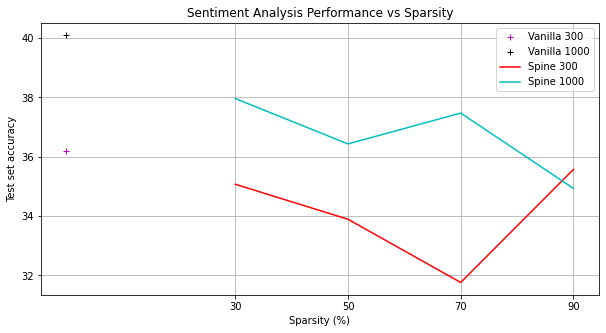

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,5))
plt.plot(vanilla_300_scores[0][0], vanilla_300_scores[0][1], 'm+', label='Vanilla 300')
plt.plot(vanilla_1000_scores[0][0], vanilla_1000_scores[0][1], 'k+', label='Vanilla 1000')
# plt.plot(percents, hoyer_001_300_scores[:,1], 'b', label='Hoyer 300 l=0.01')
# plt.plot(percents, hoyer_100_300_scores[:,1], 'g', label='Hoyer 300 l=1')
# plt.plot(percents, hoyer_1e05_1000_scores[:,1], label='Hoyer 1000 l=1e-05')
# plt.plot(percents, hoyer_001_300_36_scores[:,1], label='Hoyer 300 l=0.01 36h')
# plt.plot(percents, hoyer_100_300_36_scores[:,1], label='Hoyer 300 l=1 36h')
plt.plot(percents, spine_300_scores[:,1], 'r', label='Spine 300')
plt.plot(percents, spine_1000_scores[:,1], 'c', label='Spine 1000')
plt.title('Sentiment Analysis Performance vs Sparsity')
plt.xlabel('Sparsity (%)')
plt.xticks(percents)
plt.ylabel('Test set accuracy')
plt.legend()
plt.grid()
plt.show()
plt.savefig(EXPERIMENT_FOLDER_PATH+'fig1_sa.pdf')

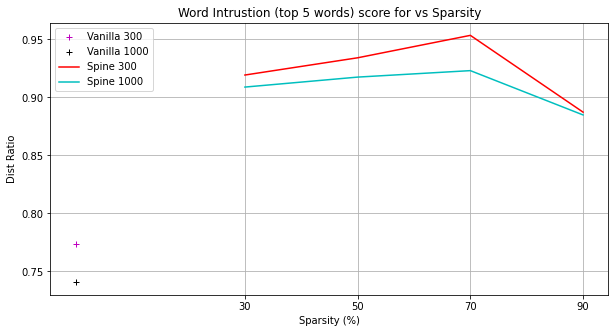

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,5))
plt.plot(vanilla_300_scores[0][0], vanilla_300_scores[0][3], 'm+', label='Vanilla 300')
plt.plot(vanilla_1000_scores[0][0], vanilla_1000_scores[0][3], 'k+', label='Vanilla 1000')
# plt.plot(percents, hoyer_001_300_scores[:,3], 'b', label='Hoyer 300 l=0.01')
# plt.plot(percents, hoyer_100_300_scores[:,3], 'g', label='Hoyer 300 l=1')
# plt.plot(percents, hoyer_1e05_1000_scores[:,3], label='Hoyer 1000 l=1e-05')
# plt.plot(percents, hoyer_001_300_36_scores[:,3], label='Hoyer 300 l=0.01 36h')
# plt.plot(percents, hoyer_100_300_36_scores[:,3], label='Hoyer 300 l=1 36h')
plt.plot(percents, spine_300_scores[:,3], 'r', label='Spine 300')
plt.plot(percents, spine_1000_scores[:,3], 'c', label='Spine 1000')
plt.title('Word Intrustion (top 5 words) score for vs Sparsity')
plt.xlabel('Sparsity (%)')
plt.xticks(percents)
plt.ylabel('Dist Ratio')
plt.legend()
plt.grid()
plt.show()
plt.savefig(EXPERIMENT_FOLDER_PATH+'fig2_intrusion.pdf')

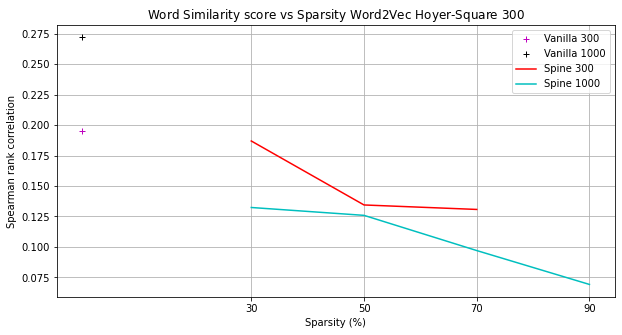

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,5))
plt.plot(vanilla_300_scores[0][0], vanilla_300_scores[0][5], 'm+', label='Vanilla 300')
plt.plot(vanilla_1000_scores[0][0], vanilla_1000_scores[0][5], 'k+', label='Vanilla 1000')
# plt.plot(percents, hoyer_001_300_scores[:,5], 'b', label='Hoyer 300 l=0.01')
# plt.plot(percents, hoyer_100_300_scores[:,5], 'g', label='Hoyer 300 l=1')
# plt.plot(percents, hoyer_1e05_1000_scores[:,5], label='Hoyer 1000 l=1e-05')
# plt.plot(percents, hoyer_001_300_36_scores[:,5], label='Hoyer 300 l=0.01 36h')
# plt.plot(percents, hoyer_100_300_36_scores[:,5], label='Hoyer 300 l=1 36h')
plt.plot(percents, spine_300_scores[:,5], 'r', label='Spine 300')
plt.plot(percents, spine_1000_scores[:,5], 'c', label='Spine 1000')
plt.title('Word Similarity score vs Sparsity Word2Vec Hoyer-Square $300$')
plt.xlabel('Sparsity (%)')
plt.xticks(percents)
plt.ylabel('Spearman rank correlation')
plt.legend()
plt.grid()
plt.show()
plt.savefig(EXPERIMENT_FOLDER_PATH+'fig3_sim.pdf')

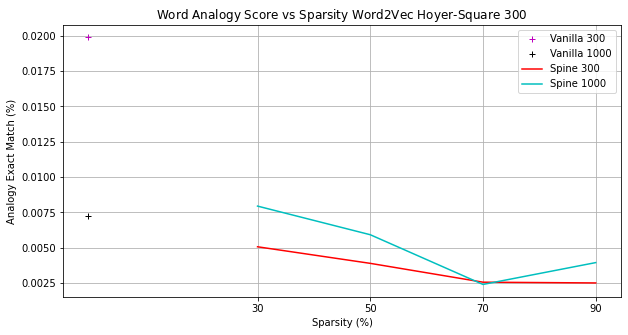

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(10,5))
plt.plot(vanilla_300_scores[0][0], vanilla_300_scores[0][7], 'm+', label='Vanilla 300')
plt.plot(vanilla_1000_scores[0][0], vanilla_1000_scores[0][7], 'k+', label='Vanilla 1000')
# plt.plot(percents, hoyer_001_300_scores[:,7], 'b', label='Hoyer 300 l=0.01')
# plt.plot(percents, hoyer_100_300_scores[:,7], 'g', label='Hoyer 300 l=1')
# plt.plot(percents, hoyer_1e05_1000_scores[:,7], label='Hoyer 1000 l=1e-05')
# plt.plot(percents, hoyer_001_300_36_scores[:,7], label='Hoyer 300 l=0.01 36h')
# plt.plot(percents, hoyer_100_300_36_scores[:,7], label='Hoyer 300 l=1 36h')
plt.plot(percents, spine_300_scores[:,7], 'r', label='Spine 300')
plt.plot(percents, spine_1000_scores[:,7], 'c', label='Spine 1000')
plt.title('Word Analogy Score vs Sparsity Word2Vec Hoyer-Square $300$')
plt.xlabel('Sparsity (%)')
plt.xticks(percents)
plt.ylabel('Analogy Exact Match (%)')
plt.legend()
plt.grid()
plt.show()
plt.savefig(EXPERIMENT_FOLDER_PATH+'fig4_wa.pdf')

## Intrusion test

In [0]:
def intrusion_small(paths_list, is_spine, k):
    scores = np.zeros(shape=(len(paths_list),7))

    for i in range(len(paths_list)):
        if is_spine:
            embedding_weights = np.load(paths_list[i])['arr_0']
        else:
            embedding_weights = np.load(paths_list[i])['a']
        
        # intrusion
        tic = time.perf_counter()
        intrusion_score = word_intrusion_experiment(embedding_weights, k, N=10)
        toc = time.perf_counter()
        scores[i,3] = intrusion_score
        scores[i,4] = toc-tic
        print(intrusion_score)

    return scores

In [0]:
paths = [hoyer_001_300_paths, hoyer_100_300_paths, [vanilla_300_path], [vanilla_1000_path], spine_300_paths, spine_1000_paths]
labels = [False, False, False, False, True, True]
names = ['hoyer001', 'hoyer100', 'vanilla300', 'vanilla1000', 'spine300', 'spine1000']

for i in range(len(paths)):
    scores = intrusion_small(paths[i], is_spine=labels[i], k=3)
    np.save(EXPERIMENT_FOLDER_PATH+names[i], scores)

In [0]:
names = ['hoyer001', 'hoyer100', 'vanilla300', 'vanilla1000', 'spine300', 'spine1000']
file_names = []
for i in range(len(names)):
    file_names.append(EXPERIMENT_FOLDER_PATH+names[i]+'.npy')

hoyer_001_300_intrusion = np.load(file_names[0])
hoyer_100_300_intrusion = np.load(file_names[1])
vanilla_300_intrusion = np.load(file_names[2])
vanilla_1000_intrusion = np.load(file_names[3])
spine_300_intrusion = np.load(file_names[4])
spine_1000_intrusion = np.load(file_names[5])

In [0]:
hoyer_001_300_intrusion

array([[ 0.        ,  0.        ,  0.        ,  0.72447603, 46.60466031,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.72315176, 41.07722461,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.72334879, 31.73611289,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.73605402, 25.63005232,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.71552889, 15.61937351,
         0.        ,  0.        ]])

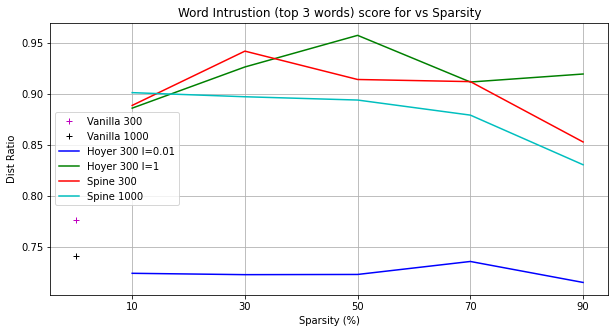

In [0]:
plt.figure(figsize=(10,5))
plt.plot(vanilla_300_intrusion[0][0], vanilla_300_intrusion[0][3], 'm+', label='Vanilla 300')
plt.plot(vanilla_1000_intrusion[0][0], vanilla_1000_intrusion[0][3], 'k+', label='Vanilla 1000')
plt.plot(percents, hoyer_001_300_intrusion[:,3], 'b', label='Hoyer 300 l=0.01')
plt.plot(percents, hoyer_100_300_intrusion[:,3], 'g', label='Hoyer 300 l=1')
plt.plot(percents, spine_300_intrusion[:,3], 'r', label='Spine 300')
plt.plot(percents, spine_1000_intrusion[:,3], 'c', label='Spine 1000')
plt.title('Word Intrustion (top 3 words) score for vs Sparsity')
plt.xlabel('Sparsity (%)')
plt.xticks(percents)
plt.ylabel('Dist Ratio')
plt.legend()
plt.grid()
plt.show()

# t-SNE plot for Hoyer

In [0]:
def plot_tsne(X, mapping, n_iter=500, n_jobs = None):
    tsne = TSNECUDA(n_components = 2)

    fig = plt.figure(figsize=(30,30))
    ax = fig.gca()
    
    trans = tsne.fit_transform(X)

    coordinates = zip(*trans)
    ax.scatter(*coordinates)

    LABELSIZE = 30
    for i in range(len(trans)):
      ax.annotate(mapping[i], xy=trans[i], textcoords='data', size = LABELSIZE)
    
    plt.grid()
    plt.show()

    return fig

In [0]:
def t_SNE(embedding_dict, embedding_weights):
  # 2D
  sample_indices = list(range(100,200))
  sample_indices = []
  sample_indices.extend([embedding_dict[i] for i in ['german', 'english', 'french', 'spanish', 'british', 'american', 'italian', 'indian', 'chinese', 'thai', 'mexican', 'canadian', 'greek', 'russian']])
  sample_indices.extend([embedding_dict[name] for name in ['girl', 'boy', 'queen', 'king', 'man', 'woman', 'basketball', 'football', 'cat', 'dog', 'love', 'hate', 'son', 'daughter', 'country', 'city', 'state']])
  sample_indices.extend([embedding_dict[name] for name in ['prince', 'princess', 'small', 'large', 'big', 'life', 'death']])
  sample_indices.extend([embedding_dict[name] for name in ['university', 'school', 'college', 'teacher', 'math', 'algebra', 'calculus', 'history', 'art', 'science']])
  sample_indices.extend([embedding_dict[name] for name in ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra', 'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']])
  sample_indices.extend([embedding_dict[name] for name in ['bird', 'deer', 'bear', 'dog', 'cat', 'lion', 'frog', 'elephant', 'giraffe', 'fox', 'hippopotamus', 'monkey', 'turtle', 'snake', 'fish']])
  sample_indices.extend([embedding_dict[name] for name in ['mom', 'dad', 'son', 'daughter', 'family', 'grandmother', 'grandfather', 'brother', 'sister']])

  sample_indices = list(set(sample_indices))
  index2word = {value: key for key, value in embedding_dict.items()}
  subsample_weights = embedding_weights[sample_indices]
  sub_mapping = [index2word[i] for i in sample_indices]
  plot_tsne(subsample_weights, sub_mapping)


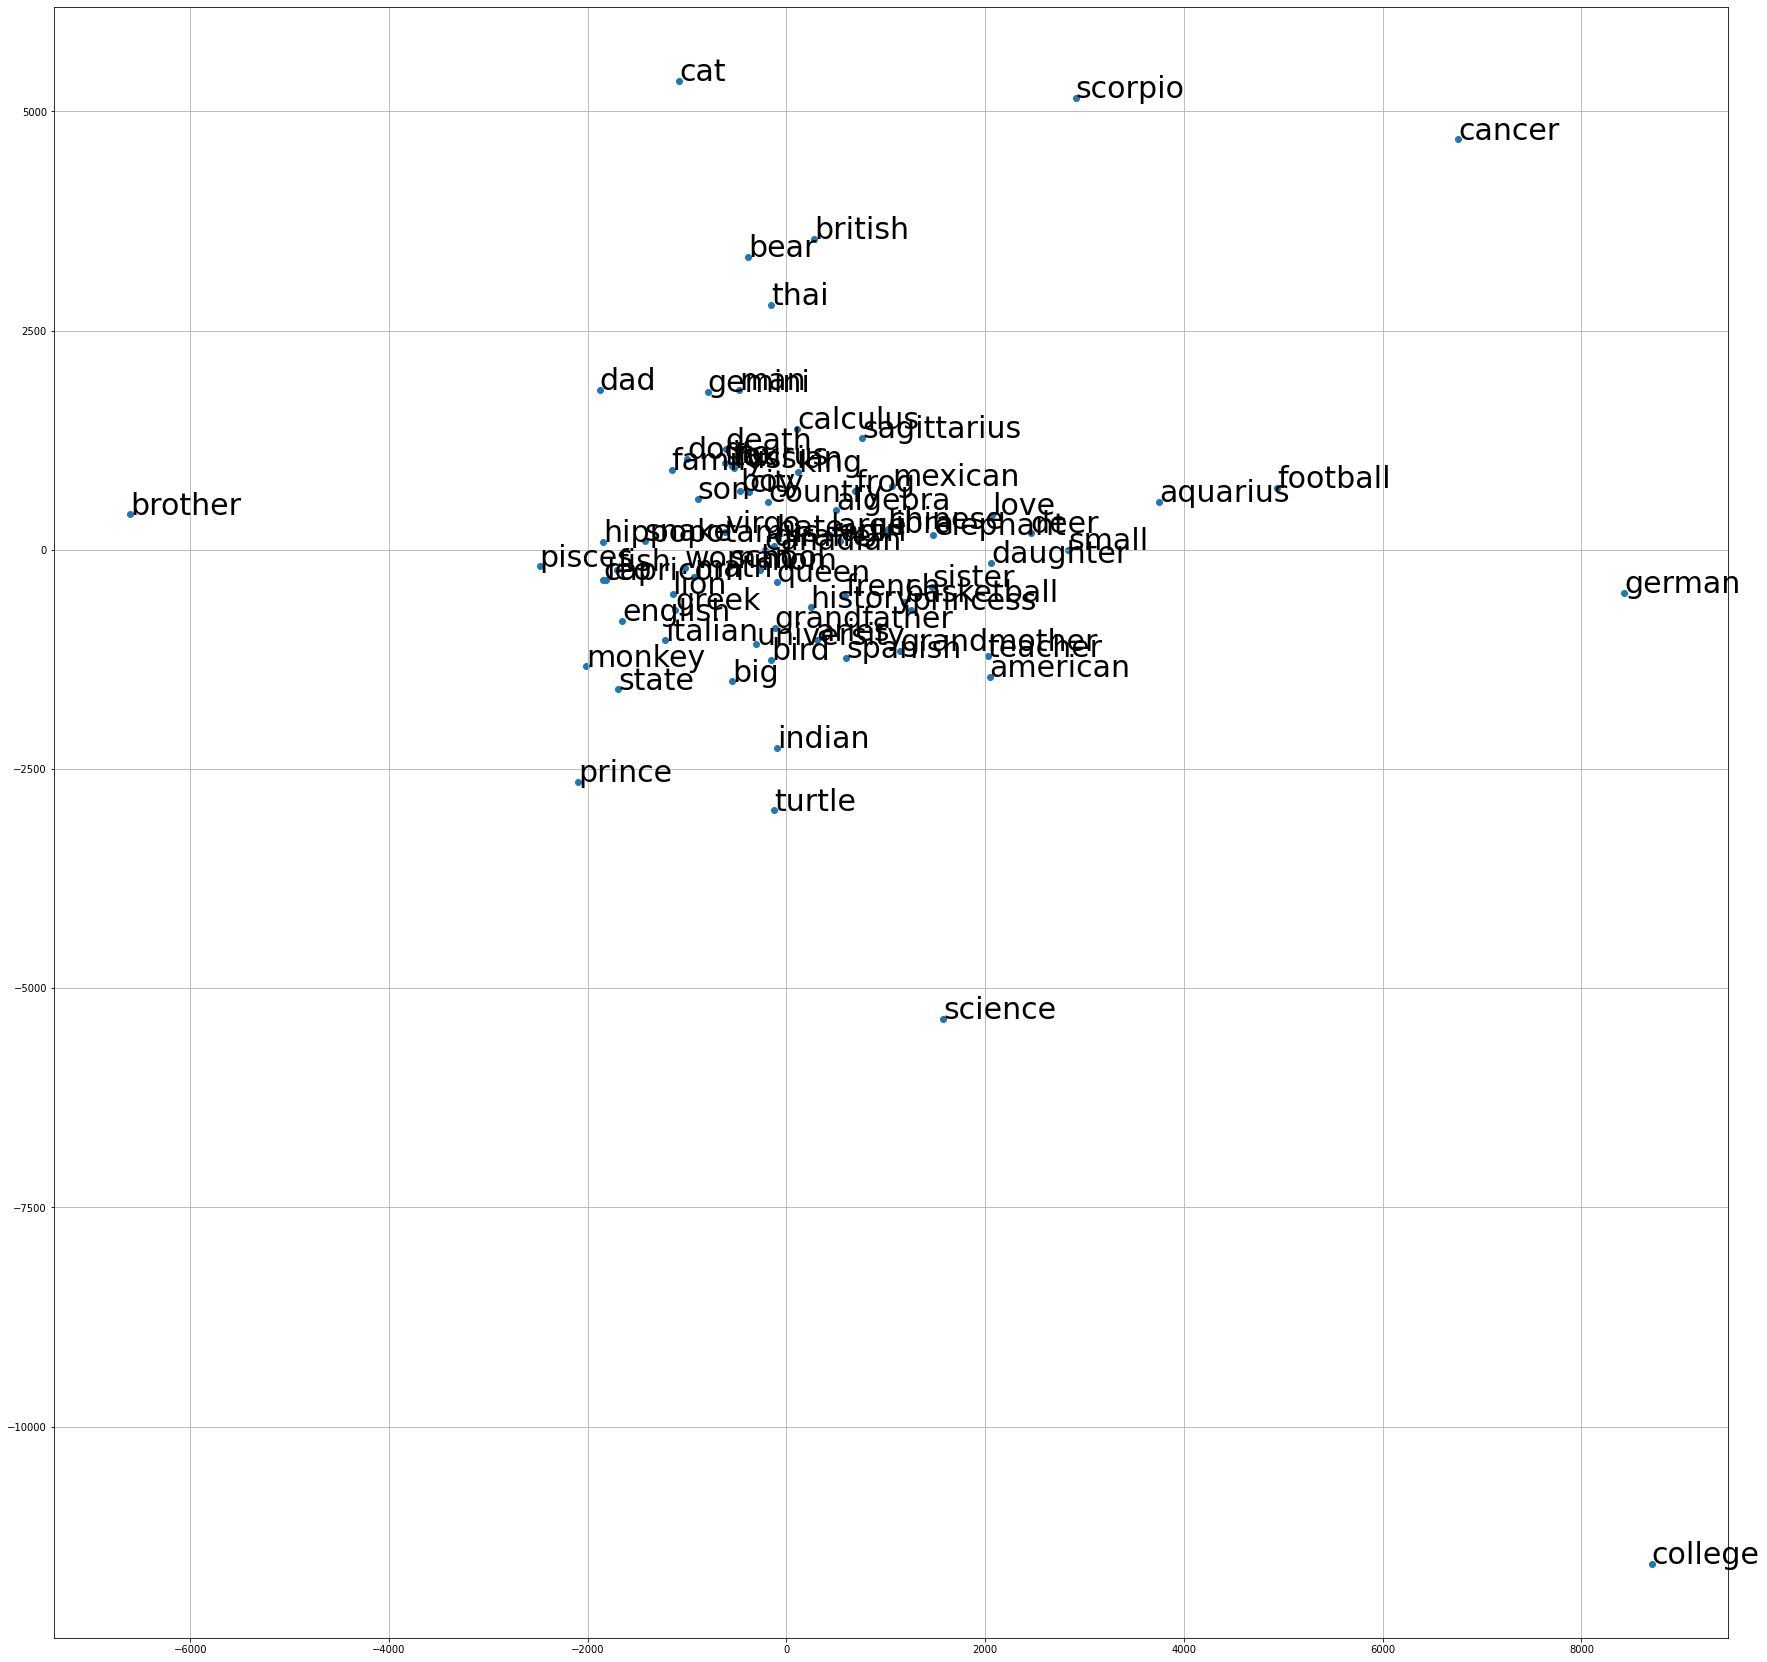

In [29]:
# Have verified this works for analogies and t-SNE -- Aneesh

hoyer_10_path = WAKU_DIR + '/embeddings/hoyer_10.0/'+'300_10.0_90_embeddings.npz'
hoyer_1e_05_path = WAKU_DIR + '/embeddings/hoyer_1e-05/'+'300_1e-05_90_embeddings.npz'

# run_tasks([hoyer_1e_05_path], False) I ran this after commenting out SA WS and WI 

hoyer_10_embeds = np.load(hoyer_10_path)['a']
t_SNE(embedding_dict, hoyer_10_embeds)